We begin by importing the necessary libraries..

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Used for data augmentation and preprocessing # type: ignore
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D # Used for building the model # type: ignore
from tensorflow.keras.models import Model, load_model # The model class # type: ignore
from tensorflow.keras.preprocessing import image # Used for loading images # type: ignore
from tensorflow.keras.applications.xception import Xception, preprocess_input # Used for transfer learning # type: ignore
import os # Necessary for file operations
import numpy as np # Used for array operations
from sklearn.utils import class_weight # Used for balancing classes
import matplotlib.pyplot as plt # Used for plotting images
import matplotlib.image as mpimg # Used for displaying images
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib.animation import FuncAnimation

Useful functions and classes

In [3]:
def count_images_in_class(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

# Function to display generator information
def display_generator_info(generator, name):
    print(f"Displaying information for {name}:")
    batch_x, batch_y = next(generator)
    print(f"Batch size: {len(batch_x)}")
    print(f"Image shape: {batch_x[0].shape}")
    print(f"Labels shape: {batch_y.shape}")
    print(f"Labels: {batch_y}")
    print("\n")

def display_images_from_directory(directory, num_images=16, grid_size=(4, 4)):
    """
    Display images from a directory in a grid.
    
    Parameters:
    - directory: The directory where the images are stored.
    - num_images: Number of images to display.
    - grid_size: Tuple indicating the grid size (rows, cols).
    """
    # Get a list of image file names
    images = [os.path.join(directory, img) for img in os.listdir(directory) if img.endswith(('.png', '.jpg', '.jpeg'))]

    # Ensure we do not exceed the available images
    num_images = min(num_images, len(images))

    # Create a figure to plot the images
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(12, 12))

    # Plot each image
    for i in range(num_images):
        row = i // grid_size[1]
        col = i % grid_size[1]
        img = mpimg.imread(images[i])
        axes[row, col].imshow(img)
        axes[row, col].axis('off')

    # Hide any remaining subplots if num_images is less than grid_size[0] * grid_size[1]
    for j in range(num_images, grid_size[0] * grid_size[1]):
        row = j // grid_size[1]
        col = j % grid_size[1]
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

def display_confusion_matrix(y_true, y_pred, class_names):
    """
    Display a confusion matrix for a model's predictions.
    
    Parameters:
    - y_true: The true labels.
    - y_pred: The predicted labels.
    - class_names: The names of the classes.
    """
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create a heatmap from the confusion matrix
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def display_classification_report(y_true, y_pred, class_names):
    """
    Display a classification report for a model's predictions.
    
    Parameters:
    - y_true: The true labels.
    - y_pred: The predicted labels.
    - class_names: The names of the classes.
    """
    # Compute the classification report
    report = classification_report(y_true, y_pred, target_names=class_names)

    print(report)

In [4]:
# Define data directories
train_dir = 'image_data/train'
test_dir = 'image_data/test'

# Create an ImageDataGenerator instance with both augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input  # Preprocessing function
)

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)  # Preprocessing function 

# Load original training data 
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary'
)

# Load testing data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Add this line
)

Found 399 images belonging to 2 classes.
Found 36 images belonging to 2 classes.


In [5]:
# Display class indices for training generator
print(train_generator.class_indices)
print(test_generator.class_indices)

{'LEA': 0, 'OTHER': 1}
{'LEA': 0, 'OTHER': 1}


In [6]:
# Count images in each class
class_counts = count_images_in_class(os.path.join(train_dir))
lea_count = class_counts.get('LEA', 0)
other_count = class_counts.get('OTHER', 0)

print("My cat lea has:", lea_count, "images in training set.")
print("Other cats have:", other_count, "images in training set.")

My cat lea has: 40 images in training set.
Other cats have: 359 images in training set.


In [7]:
# Create the balanced generator for training

# balanced_train_generator = BalancedDataGenerator(
#     train_generator,
#     samples_to_generate=samples_to_generate,
#     target_class='LEA'
# )

In [8]:
# Display information for balanced training generator
print("Training Generator Info:")
display_generator_info(iter(train_generator), "Training Generator")

# Display information for test generator
print("Test Generator Info:")
display_generator_info(iter(test_generator), "Test Generator")

## Print the number of batches in the balanced training generator
print(f"Number of batches in the balanced training generator: {len(train_generator)}")

# Print the number of batches in the test generator
print(f"Number of batches in the test generator: {len(test_generator)}")

Training Generator Info:
Displaying information for Training Generator:
Batch size: 32
Image shape: (299, 299, 3)
Labels shape: (32,)
Labels: [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


Test Generator Info:
Displaying information for Test Generator:
Batch size: 32
Image shape: (299, 299, 3)
Labels shape: (32,)
Labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


Number of batches in the balanced training generator: 13
Number of batches in the test generator: 2


One quick look at our training data

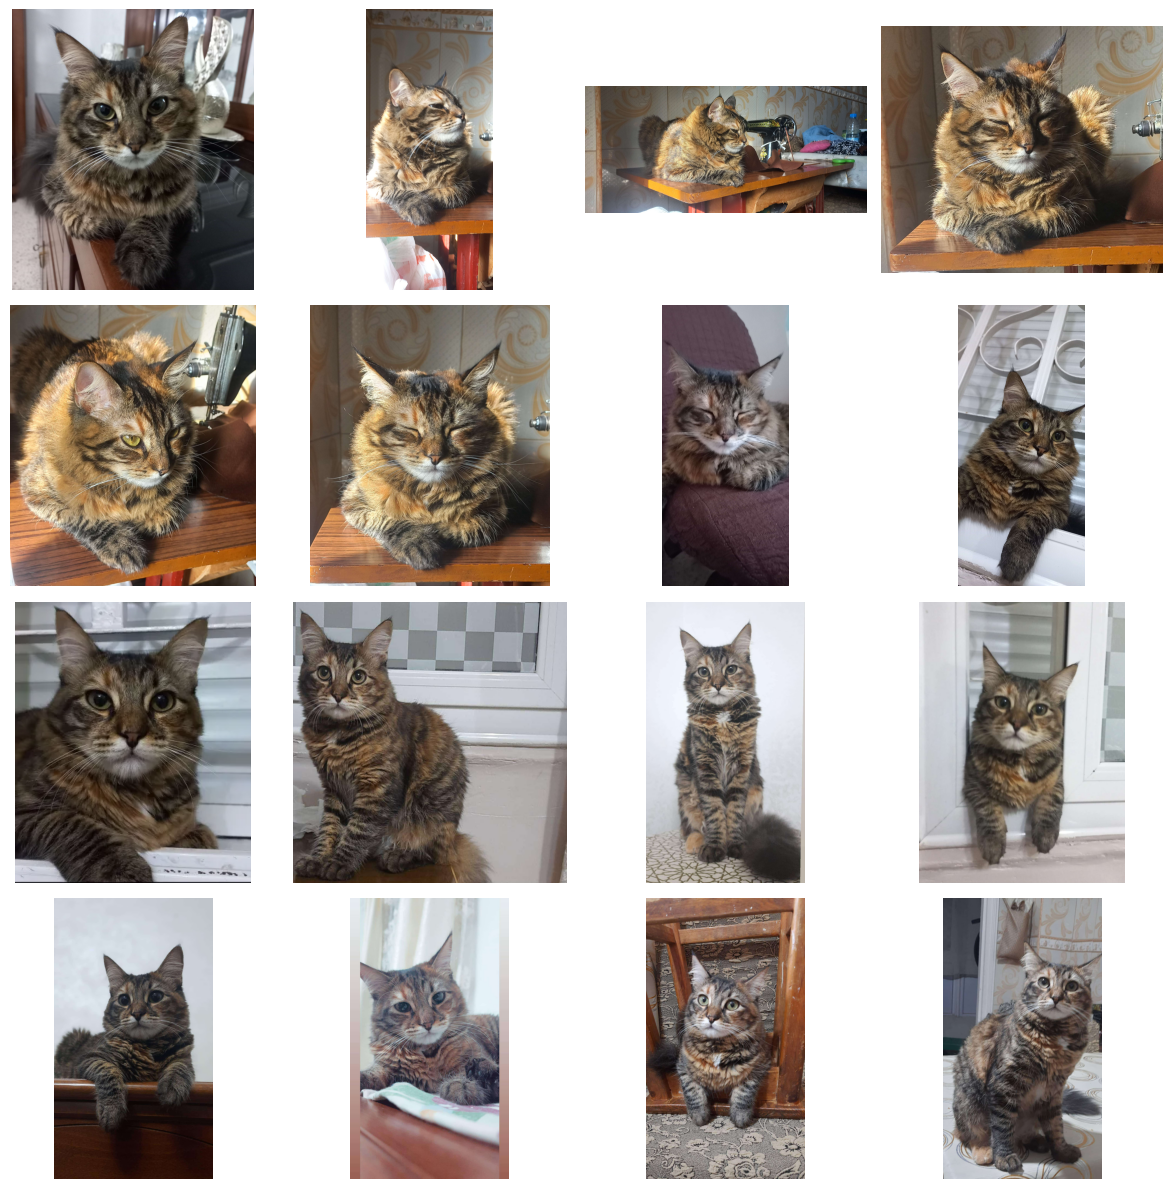

In [32]:
img_dir = './image_data/train/LEA'
display_images_from_directory(img_dir, num_images=16, grid_size=(4, 4))

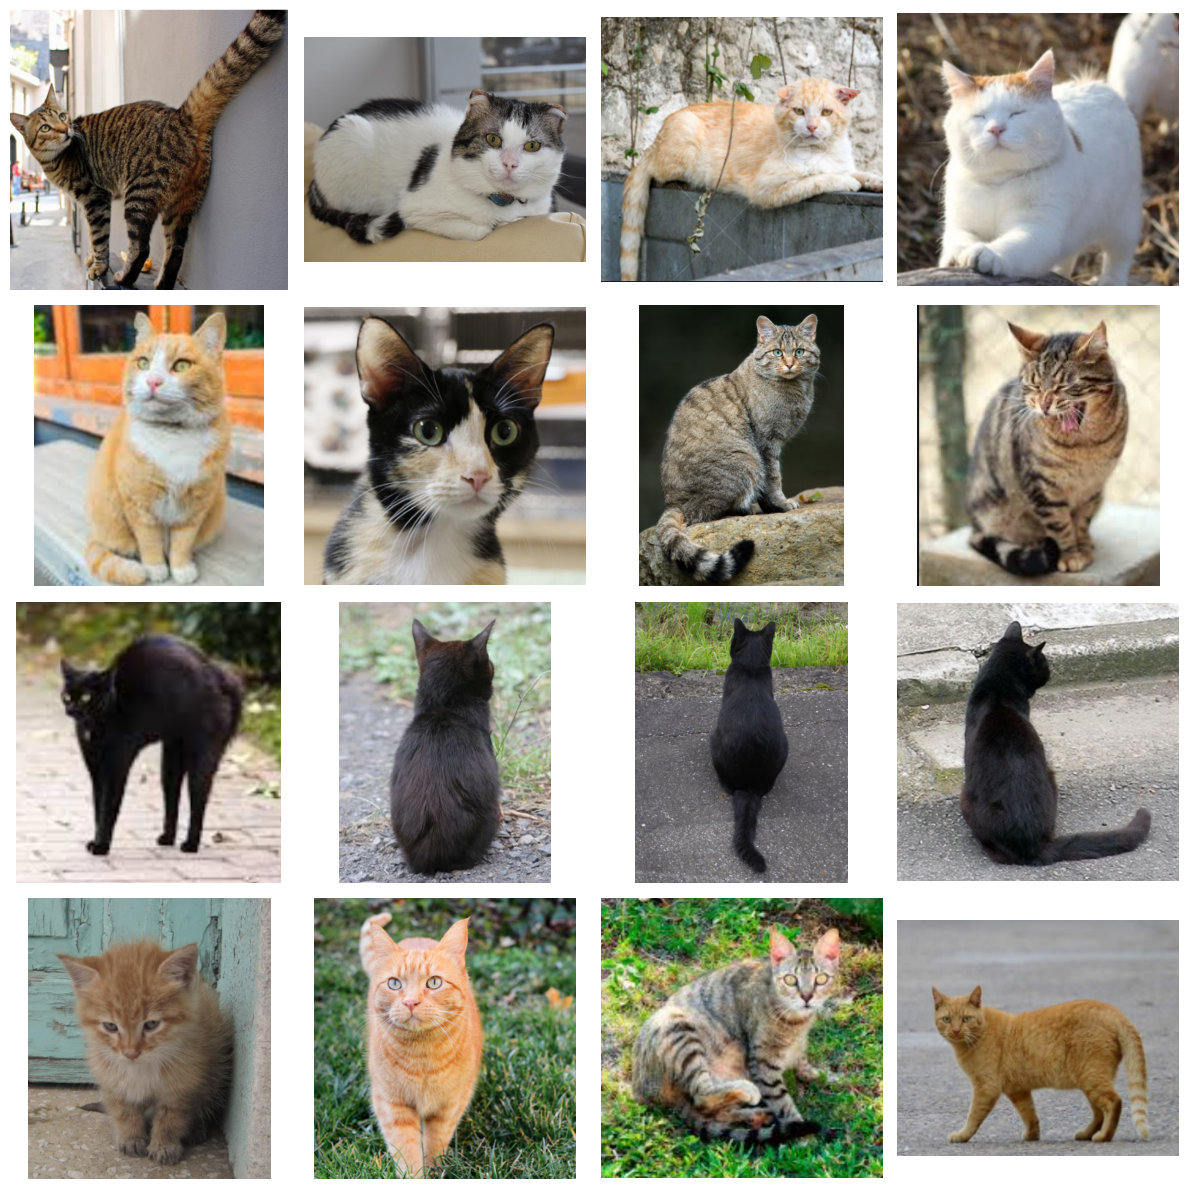

In [33]:
img_dir_oth = './image_data/train/OTHER'
display_images_from_directory(img_dir_oth, num_images=16, grid_size=(4, 4))

In [6]:
# Assuming `train_generator` is your data generator

# class_labels = train_generator.classes  # Get class labels from the generator
# class_weights = class_weight.compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(class_labels),
#     y=class_labels
# )

# # Convert to a dictionary format as required by Keras
# class_weights = {i: weight for i, weight in enumerate(class_weights)}
# print(class_weights)

{0: 4.9875, 1: 0.5557103064066853}


Building the model

In [ ]:
# Load pre-trained model and fine-tune
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'precision'])

# Train the model
results = model.fit(train_generator, validation_data=test_generator, epochs=25, shuffle = True)

# Unfreeze the convolutional base
for layer in base_model.layers:
    layer.trainable = True

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'precision'])

# Train the model
results = model.fit(train_generator, validation_data=test_generator, epochs=25, shuffle = True)

Saving the model

In [8]:
# Save the model
model.save('lea_classifier.keras')

Loading the model

In [9]:
loaded_model = load_model('lea_classifier_XC.keras')

c:\Users\zakmins\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 160 variables whereas the saved optimizer has 318 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [10]:
y_true = test_generator.classes
y_pred = (loaded_model.predict(test_generator) > 0.5).astype('int32')


c:\Users\zakmins\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step


In [60]:
y_pred = y_pred.reshape(-1)
print(y_true)
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


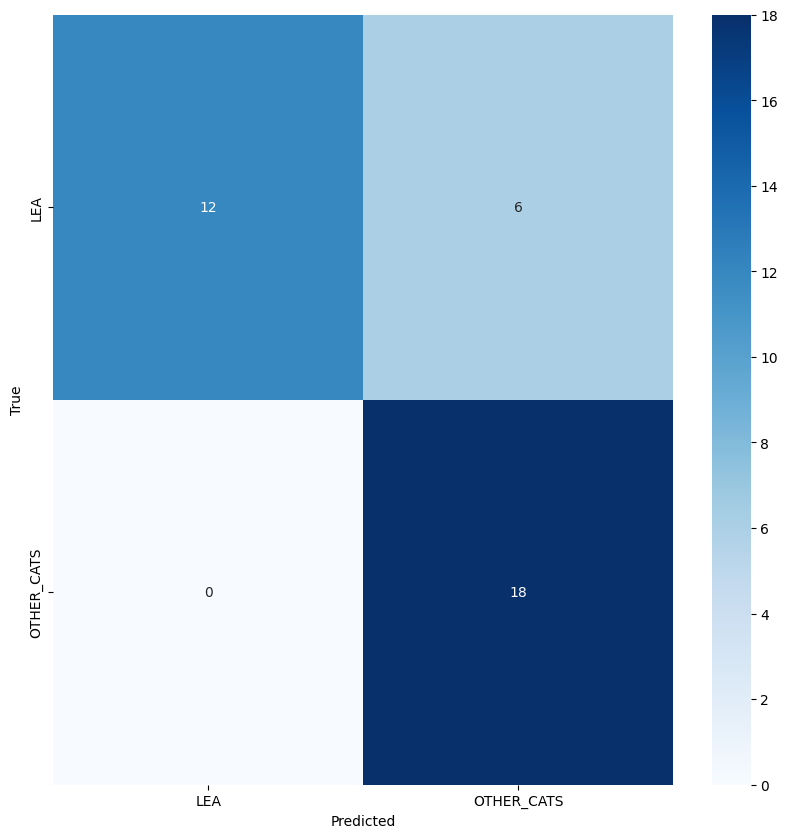

In [61]:
display_confusion_matrix(y_true, y_pred, ['LEA', 'OTHER_CATS'])

In [64]:
display_classification_report(y_true, y_pred, ['LEA', 'OTHER_CATS'])

              precision    recall  f1-score   support

         LEA       1.00      0.67      0.80        18
  OTHER_CATS       0.75      1.00      0.86        18

    accuracy                           0.83        36
   macro avg       0.88      0.83      0.83        36
weighted avg       0.88      0.83      0.83        36



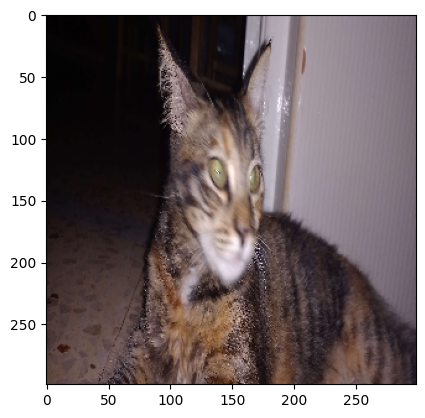

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
Image name:  \20230906_231828.jp
Image label:  [[1]]
Predicted probability: [[0.55499196]]
It is not LEA!


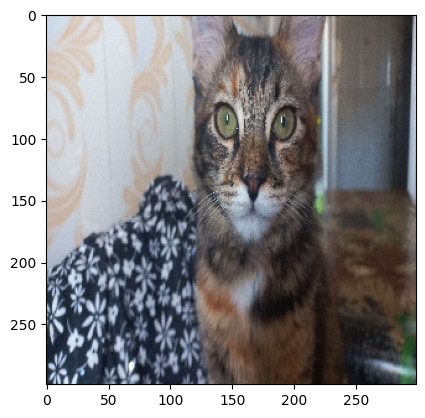

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
Image name:  \20230927_145244.jp
Image label:  [[1]]
Predicted probability: [[0.9998389]]
It is not LEA!


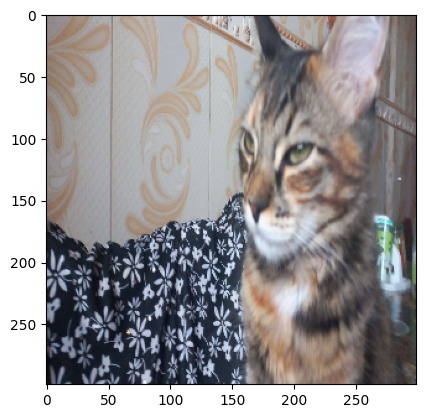

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
Image name:  \20230927_145300.jp
Image label:  [[1]]
Predicted probability: [[1.]]
It is not LEA!


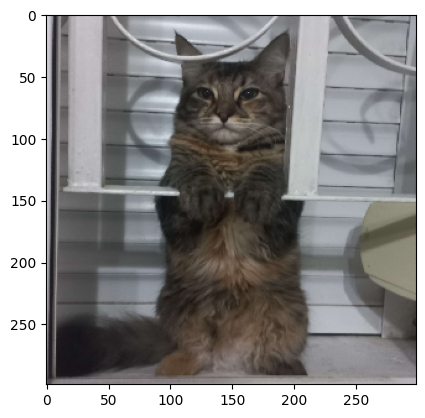

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
Image name:  \20231111_200159.jp
Image label:  [[0]]
Predicted probability: [[0.16517007]]
It is LEA!


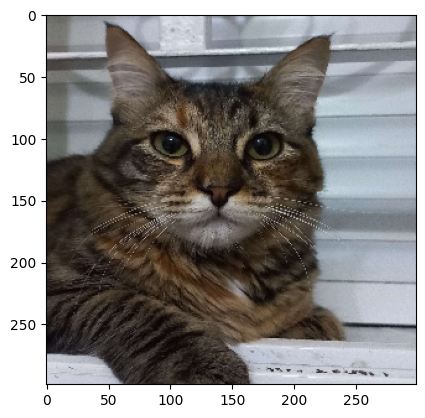

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
Image name:  \20231206_191051.jp
Image label:  [[0]]
Predicted probability: [[2.356664e-05]]
It is LEA!


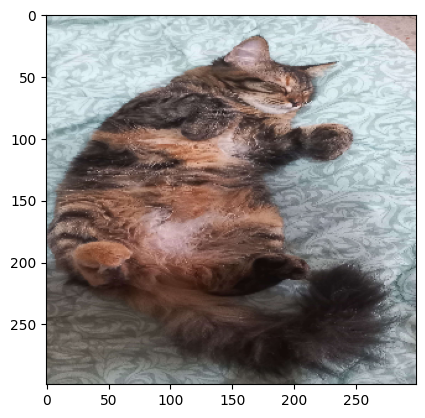

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
Image name:  \20231212_165249.jp
Image label:  [[0]]
Predicted probability: [[0.0758045]]
It is LEA!


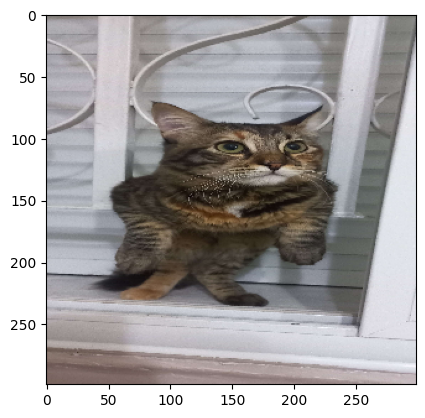

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
Image name:  \20231216_204921.jp
Image label:  [[0]]
Predicted probability: [[0.04829071]]
It is LEA!


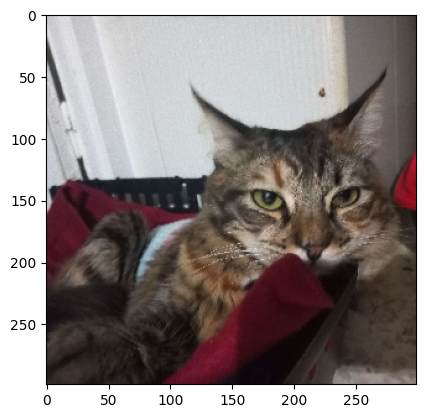

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
Image name:  \20240102_234714.jp
Image label:  [[1]]
Predicted probability: [[0.98986155]]
It is not LEA!


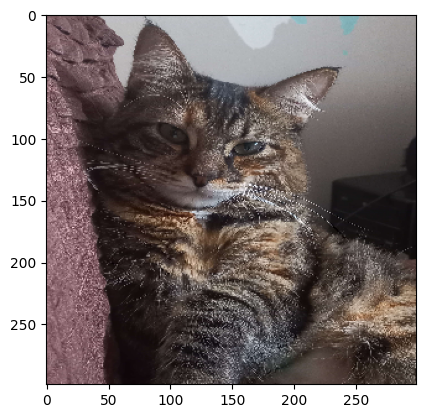

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
Image name:  \20240115_124516.jp
Image label:  [[0]]
Predicted probability: [[0.00183852]]
It is LEA!


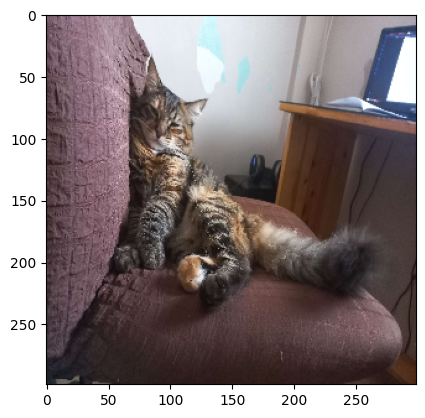

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
Image name:  \20240115_124643.jp
Image label:  [[0]]
Predicted probability: [[0.05788824]]
It is LEA!


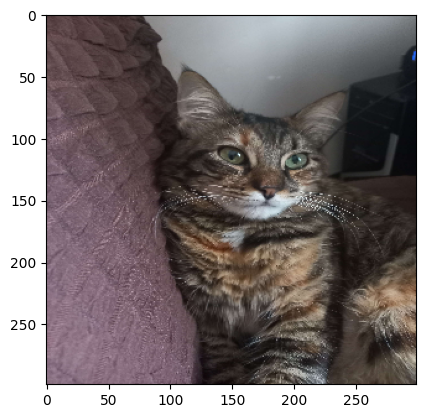

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
Image name:  \20240115_124736.jp
Image label:  [[0]]
Predicted probability: [[0.00316792]]
It is LEA!


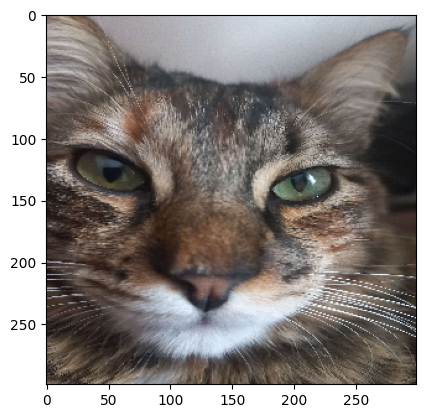

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
Image name:  \20240115_124740.jp
Image label:  [[0]]
Predicted probability: [[0.00728702]]
It is LEA!


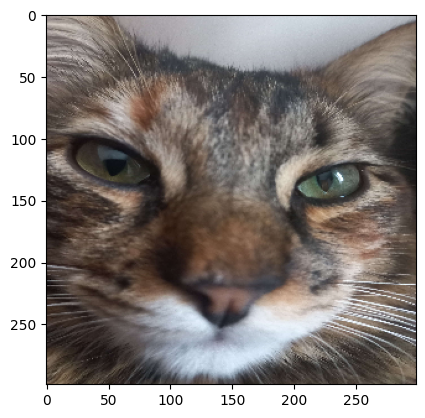

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
Image name:  \20240115_124742.jp
Image label:  [[0]]
Predicted probability: [[0.04541937]]
It is LEA!


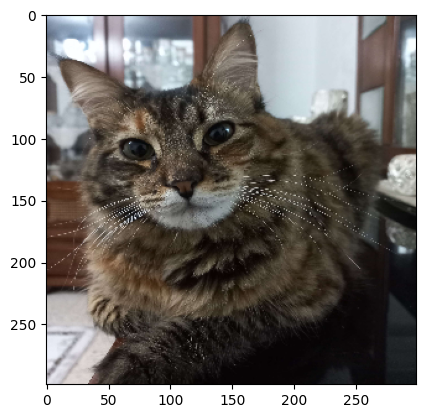

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
Image name:  \20240416_054551.jp
Image label:  [[0]]
Predicted probability: [[0.00615598]]
It is LEA!


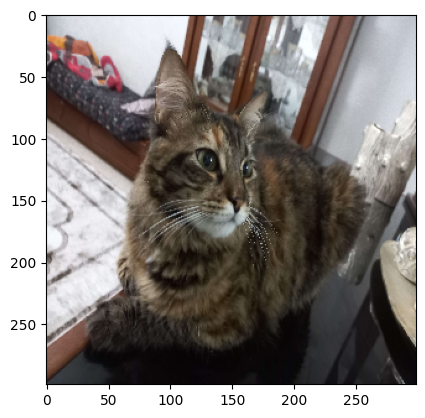

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
Image name:  \20240416_054610.jp
Image label:  [[0]]
Predicted probability: [[0.4029257]]
It is LEA!


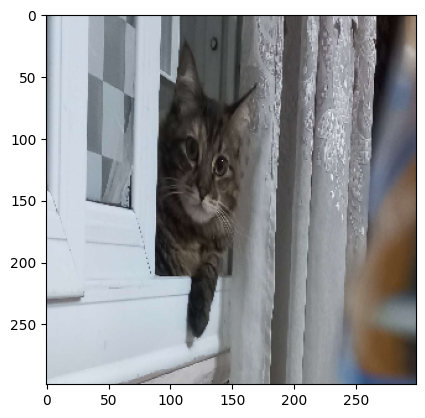

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
Image name:  \20240418_210709.jp
Image label:  [[1]]
Predicted probability: [[0.9962554]]
It is not LEA!


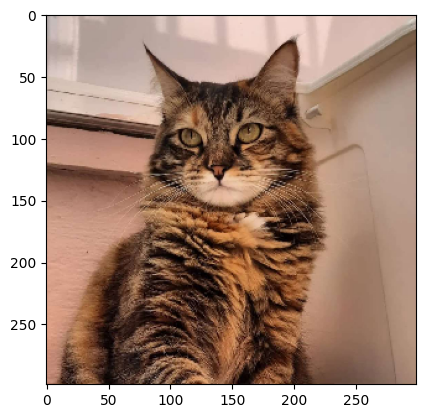

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
Image name:  \Screenshot_20240521_163714_Instagram.jp
Image label:  [[0]]
Predicted probability: [[1.13248966e-07]]
It is LEA!


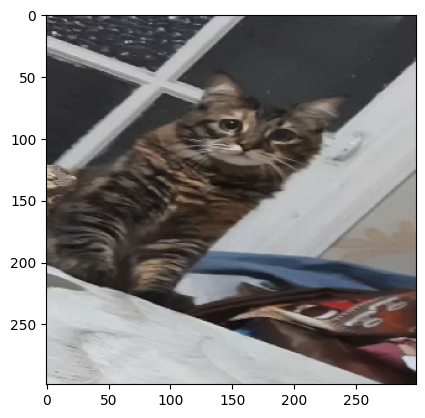

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
Image name:  \VideoCapture_20240508-003558.jp
Image label:  [[1]]
Predicted probability: [[0.9983136]]
It is not LEA!


In [67]:
# Set the directory path
directory = 'image_data/test/LEA'

# Get the list of image files in the directory
image_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.jpg') or f.endswith('.png')]

# Iterate over the image files
for image_file in image_files:
    # Load the image
    img = image.load_img(image_file, target_size=(299, 299))
    
    # Convert the image to a NumPy array
    x = image.img_to_array(img)
    x = preprocess_input(x)
    # Add an extra dimension to the array
    x = np.expand_dims(x, axis=0)
    
    # Display the image
    plt.imshow(img)
    plt.show()
    
    # Predict the class label
    images = np.vstack([x])
    probability = loaded_model.predict(images)
    classes = (loaded_model.predict(images) > 0.5).astype('int32')
    
    # Print the file name and predicted class label
    print('Image name: ', image_file.strip('./image_data/test/LEA/'))
    print('Image label: ', classes)
    print('Predicted probability:', probability)

    # Print the predicted class label
    if classes == 0:
        print('It is LEA!')
    else:
        print('It is not LEA!')

In [69]:
results = loaded_model.evaluate(test_generator)

# Print all the metrics
for name, value in zip(loaded_model.metrics_names, results):
    print(f"{name}: {value}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8264 - loss: 1.3837 - precision: 0.7333
loss: 1.328377366065979
compile_metrics: 0.8333333134651184


Extracting feature maps to provide an insight of how the convolutional layers of a neural network interpret the input data

In [11]:
# Load and preprocess the image
img = image.load_img('./image_data/test/LEA/20240416_054551.jpg', target_size=(299, 299))
x = image.img_to_array(img)
x = preprocess_input(x)
x = np.expand_dims(x, axis=0)

# Extract feature maps from each layer
feature_maps_list = []
for layer in loaded_model.layers:
    if 'conv' in layer.name or 'mixed' in layer.name:
        intermediate_layer_model = Model(inputs=loaded_model.input, outputs=layer.output)
        feature_maps = intermediate_layer_model.predict(x)
        if len(feature_maps.shape) == 4:
            feature_maps = feature_maps[0]  # Remove the batch dimension
        feature_maps_list.append((layer.name, feature_maps))
        print(f"Extracted feature maps from layer: {layer.name}, shape: {feature_maps.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
Extracted feature maps from layer: block1_conv1, shape: (149, 149, 32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Extracted feature maps from layer: block1_conv1_bn, shape: (149, 149, 32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Extracted feature maps from layer: block1_conv1_act, shape: (149, 149, 32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Extracted feature maps from layer: block1_conv2, shape: (147, 147, 64)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
Extracted feature maps from layer: block1_conv2_bn, shape: (147, 147, 64)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
Extracted feature maps from layer: block1_conv2_act, shape: (147, 147, 64)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
Extracted feature maps from layer: block2_sepconv1, shape: (147, 147, 128)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
Extracted feature maps from layer: block2_sepconv1_bn, shape: (147, 147, 128)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
Extracted feature maps from layer: block2_sepconv2_act, 

In [14]:
# Calculate the total number of frames
frame_indices = []
for layer_idx, (layer_name, feature_maps) in enumerate(feature_maps_list[:10]):  # Only take the first 10 layers
    num_filters = feature_maps.shape[-1]
    frame_indices.extend((layer_idx, filter_idx) for filter_idx in range(num_filters))

total_frames = len(frame_indices)
print(f"Total frames: {total_frames}")

def create_animation(feature_maps_list, frame_indices):
    fig = plt.figure(figsize=(6, 6))
    plt.axis('off')
    im = plt.imshow(feature_maps_list[0][1][:, :, 0], cmap='viridis')
    text = plt.text(0.05, 0.05, f'Layer: {feature_maps_list[0][0]} Filter: {1}', transform=fig.transFigure, fontsize=16, color='darkblue')

    def animate_func(frame):
        layer_idx, filter_idx = frame_indices[frame]
        layer_name, feature_maps = feature_maps_list[layer_idx]
        feature_map = feature_maps[:, :, filter_idx]

        # Normalize the feature map for better visualization
        feature_map -= feature_map.mean()
        feature_map /= (feature_map.std() + 1e-5)  # Avoid division by zero
        feature_map *= 64
        feature_map += 128
        feature_map = np.clip(feature_map, 0, 255).astype('uint8')

        im.set_array(feature_map)
        text.set_text(f'Layer: {layer_name} Filter: {filter_idx + 1}')
        return [im]

    plt.close()  # Prevents the initial plot from displaying
    
    return FuncAnimation(fig, animate_func, frames=total_frames, interval=100)

# Create the animation
ani = create_animation(feature_maps_list, frame_indices)

# Save the animation to a file to check outside the interactive environment
ani.save('feature_maps_animation_1.gif', writer='pillow', fps=5)

# Display the animation
plt.show()

Total frames: 800
